# 预测序列的后续值

预测一个序列的后续值是比较常见的问题，这里将介绍下怎样预测后面一串序列的值。  

但实际上预测序列的后续值也可以由一个点一个点这样预测，下面两个例子分别展示了一个一个点预测和一次性得到多个点的方法：  

---------------

#### 【方式一：一个点一个点预测】
假设我们已经得到了一个训练好的模型。现在有一个目标序列 X={1,2,3,4,5,6,7,8,9} ，但已知序列为 x={1,2,3,4,5} ，需要预测后面的 {6,7,8,9}。  
* 模型第一次输入 x={1,2,3,4,5}，得到后续的点 {6}。 
* 模型第二次输入 x={2,3,4,5,6}，得到后续的点 {7}。  
* 模型第三次输入 x={3,4,5,6,7}，得到后续的点 {8}。

按照这个方式最终就可以得到完整的序列 X。

----------------

#### 【方式二：一次性预测多个点】

假设我们已经得到了一个训练好的模型，模型输入要求 5 个点，提供的输出为后续 4 个点。  

那么只需要把 x={1,2,3,4,5} 送入模型，他自然会输出 {6,7,8,9}

-----------------

看上去第一种方法比较繁琐，因为每输出一次就要重新构建输入，但繁琐的好处在于其灵活性比第二种方法高。  

现在来思考这么一个场景：  
让你来预测一个城市电网某天某段时刻的用电量，假设输入数据是数小时的用电量，那么你需要输出的是一个 1x24 的行向量。  
你大可以训练一个输入 0:00 ~ 12:00 用电量（前 12 个点），输出 13:00 ~ 24:00 用电量（后 12 个点）的模型。  
现在问题来了，市领导在 10:00 开会的时候突然想看看今天城市用电量预测，可现在才 10:00 啊，你的输入条件都没满足，后面两小时的缺失部分你打算用猜的么？  
勤劳的你说：这都不是事，我再训练一个输入 0:00 ~ 10:00（前 10 个点），输出 9:00 ~ 24:00（后 14 个点） 的模型不就行了。  
第二天，气温突然从 35 度飙升至 43 度，气象局高温预警报告在早上5点的时候送至了市长办公室，市领导 8:00 召开紧急会议部署防暑工作，现在大大小小数十名领导都在等你的用电预测，可你的模型仍然没有满足输入条件。  

发现了吧，这么一对比第一种方案反而更省力，至少不需要你准备好几个模型。

----------

遵循由易到难的思路，这里先介绍预测一系列的方法，一个点一个点预测将在下一个案例中展开

In [1]:
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing import sequence

import numpy as np
import matplotlib.pyplot as plt

## 创建数据

创建了一个 y = sin(x) + noise 的数据集

In [2]:
np.random.seed(1024)    # 设置随机种子

x = np.linspace(-10000, 10000, num=500000)
x = np.reshape(x, (5000, 100))
y = np.sin(x) + np.random.randn(5000, 100) * 0.05   # 给 sin(x)增加噪声

## 分割数据

将前 80 个点作为模型输入，后 20 个点作为模型预测值

In [3]:
x_train = y[:, :80]
y_train = y[:, 80:]

In [4]:
x_train = np.expand_dims(x_train, axis=-1)    # 需要对数据进行维度扩充

In [5]:
x_train.shape, y_train.shape

((5000, 80, 1), (5000, 20))

## 检查数据

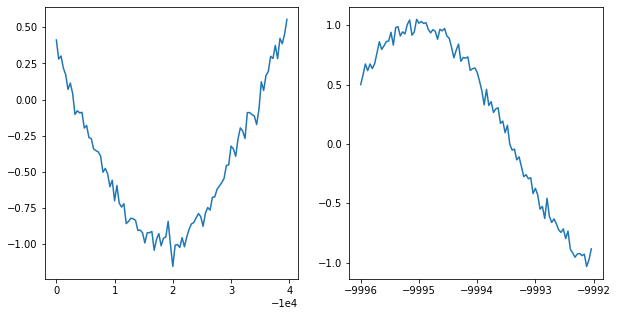

In [6]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.plot(x[0], y[0])
plt.subplot(1,2,2)
plt.plot(x[1], y[1])

## 搭建模型

这里使用了 Keras 自带的 LSTM 层。  
LSTM 和 RNN 都是用来做序列相关的网络层，在 Transformer 结构出来之前，NLP 问题都绕不开这两个结构，目前你只需要知道这两个层能用来处理连续序列问题即可，Advance 文件夹将对这两个进行深度探讨，同时也就手动实现 Transformer 结构。

In [7]:
def get_inter_layer(x):
    x = LSTM(units=100, return_sequences=True)(x)
    x = LSTM(units=50,  return_sequences=True)(x)
    x = LSTM(units=20,  return_sequences=True)(x)
    return x

In [8]:
input_layer = Input(shape=(80, 1))
inter_layer = get_inter_layer(input_layer)
flatten = Flatten()(inter_layer)
dense_1 = Dense(128)(flatten)
dense_2 = Dense(20)(dense_1)

In [9]:
model = Model(inputs=input_layer, outputs=dense_2)

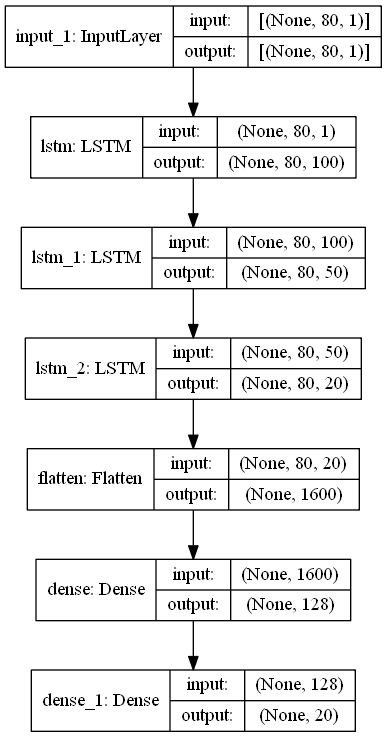

In [10]:
plot_model(model, show_shapes=True)

In [11]:
model.compile(loss='mae', optimizer='rmsprop')

In [ ]:
model.fit(x_train, y_train, verbose=1, batch_size=128, epochs=5)

Epoch 1/5


## 模型预测

In [ ]:
input_data = np.expand_dims(x_train[0], axis=0)
y_pred = model.predict(input_data)

## 绘图

In [ ]:
origin_seq = np.zeros((100))         # 原始数据
origin_seq[:80] = x_train[0,:,0]
origin_seq[80:] = y_train[0]

predict_seq = np.zeros((100))        # 预测数据=前80个点的输入 + 后20个点的预测
predict_seq[:80] = x_train[0,:,0]
predict_seq[80:] = y_pred[0]

plt.plot(predict_seq, 'r')
plt.plot(origin_seq, 'b')

图中蓝色为真实数，红色为预测数据